# Model fitting example
This is just a notbook I used to generate some examples of fitting different order polynomials to some data.

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression as LR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})
FIGSIZE=(16, 9)
np.random.seed(666)

## Generate data

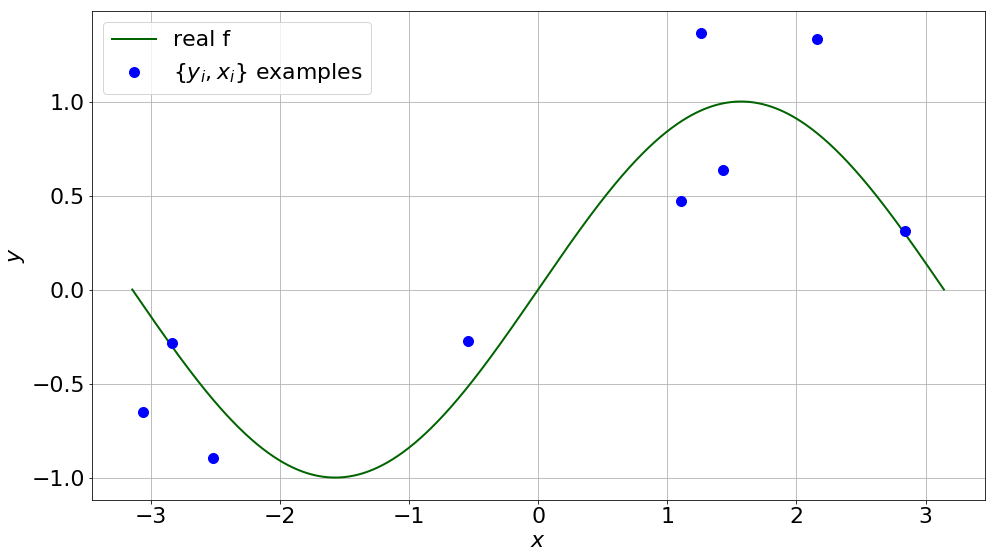

In [14]:
# Inputs
xmin, xmax = -np.pi, np.pi
#x_tr = np.linspace(xmin, xmax, 10)
x_tr = np.sort(np.random.uniform(xmin, xmax, 9))
x_ts = np.linspace(xmin, xmax, 1000)

# Latent function and noisy targets
noise = 0.4
f = np.sin(x_ts)
y = np.sin(x_tr) + np.random.randn(len(x_tr)) * noise

# Plot
def plot_data(reg=None, degree=None):
    pl.plot(x_ts.flatten(), f, 'darkgreen', linewidth=2, label='real f')
    pl.plot(x_tr.flatten(), y, 'blue', marker='o', markersize=10, linewidth=0, label='$\{y_i, x_i\}$ examples')
    if reg is not None:
        h = reg.predict(x_ts[:, np.newaxis])
        pl.plot(x_ts.flatten(), h, 'darkred', linewidth=2, label='learned h, degree={}'.format(degree))
    pl.xlabel('$x$')
    pl.ylabel('$y$')
    pl.legend()
    pl.grid()
    
pl.figure(figsize=FIGSIZE)
plot_data()
pl.show()

## Train some models

In [15]:
# Polynomial orders
final_degree = 7
degrees = range(final_degree+1)

models = []
for d in degrees:
    model = make_pipeline(PolynomialFeatures(degree=d), LR())
    model.fit(x_tr[:, np.newaxis], y)
    models.append((model, d))

## Plot the predictions

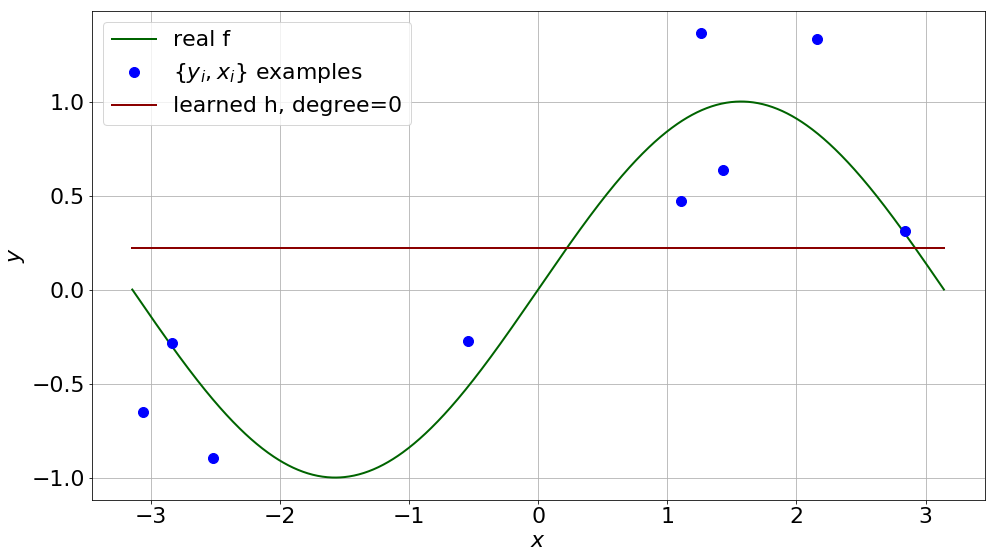

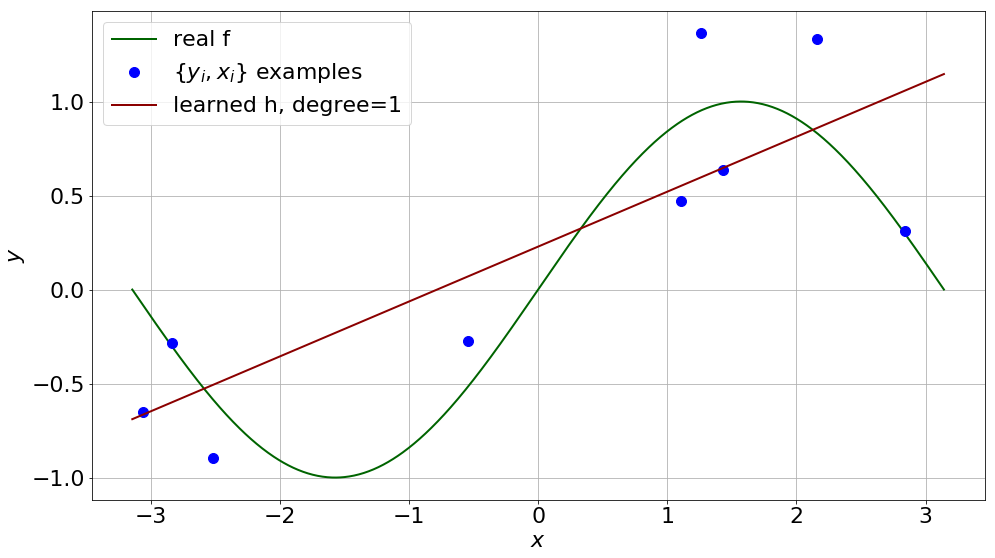

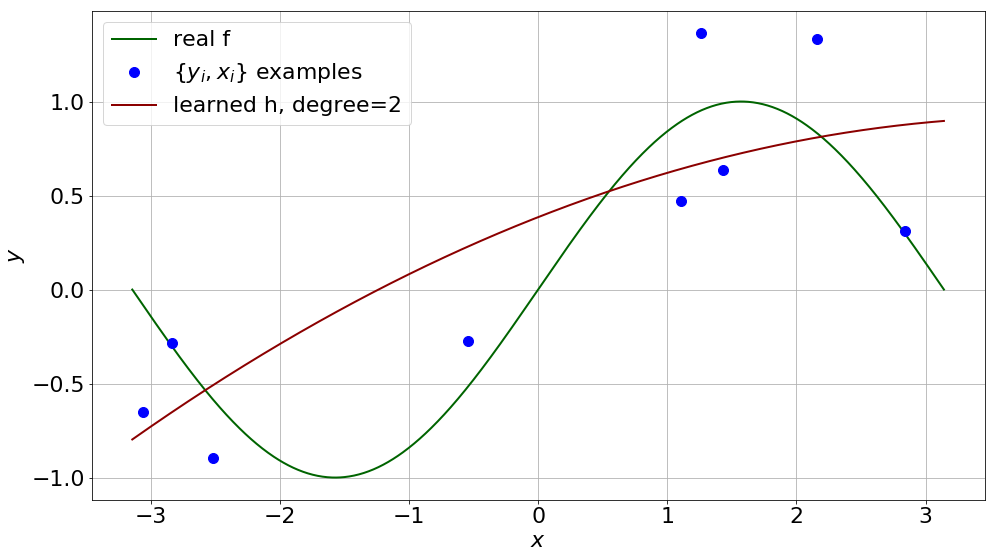

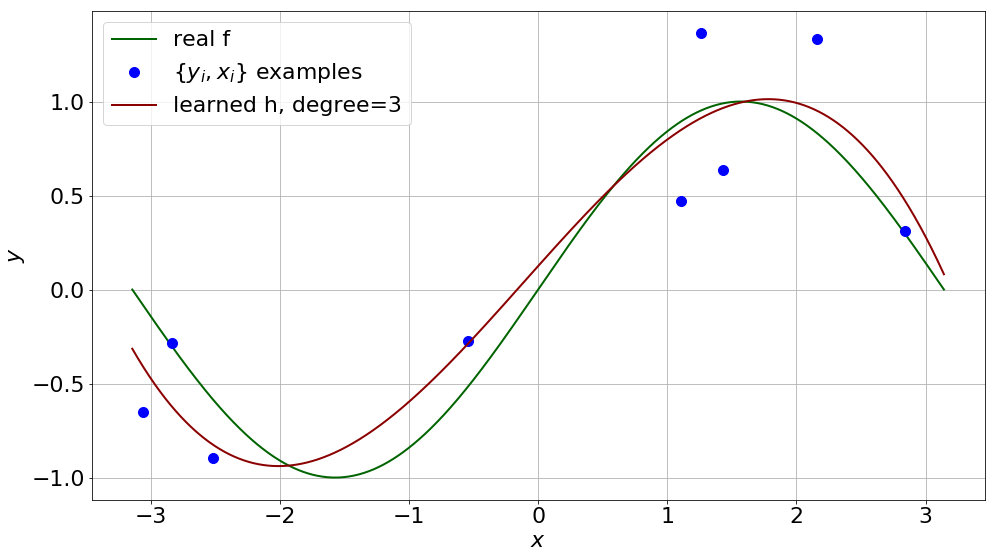

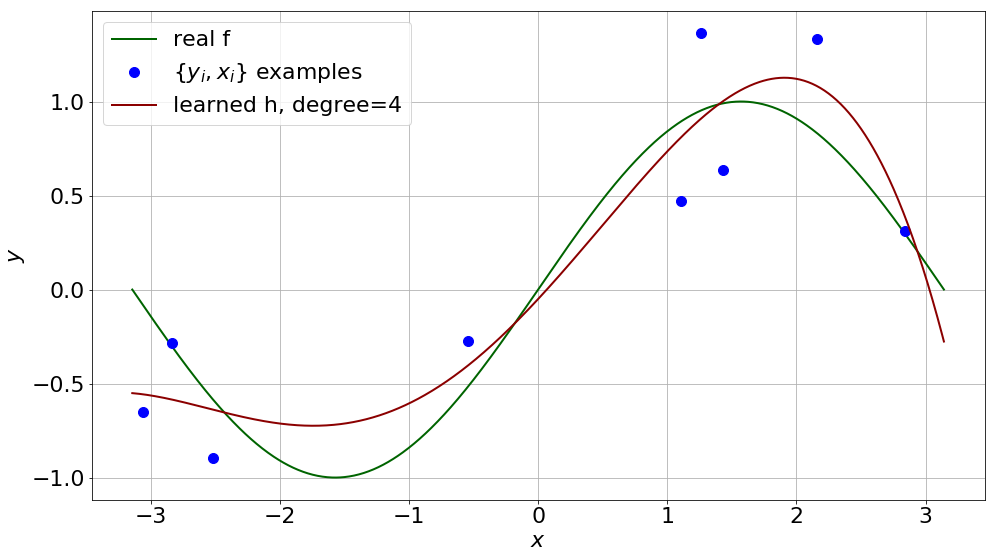

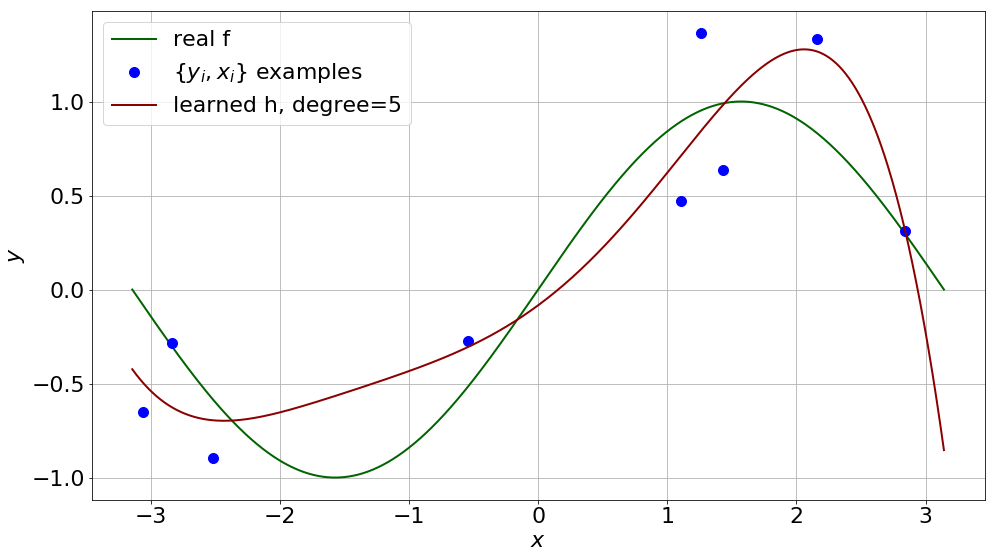

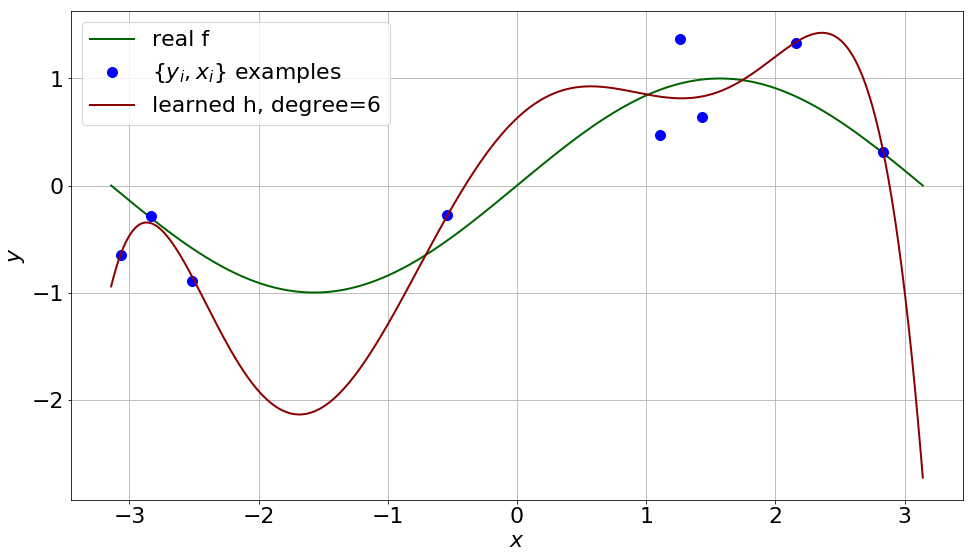

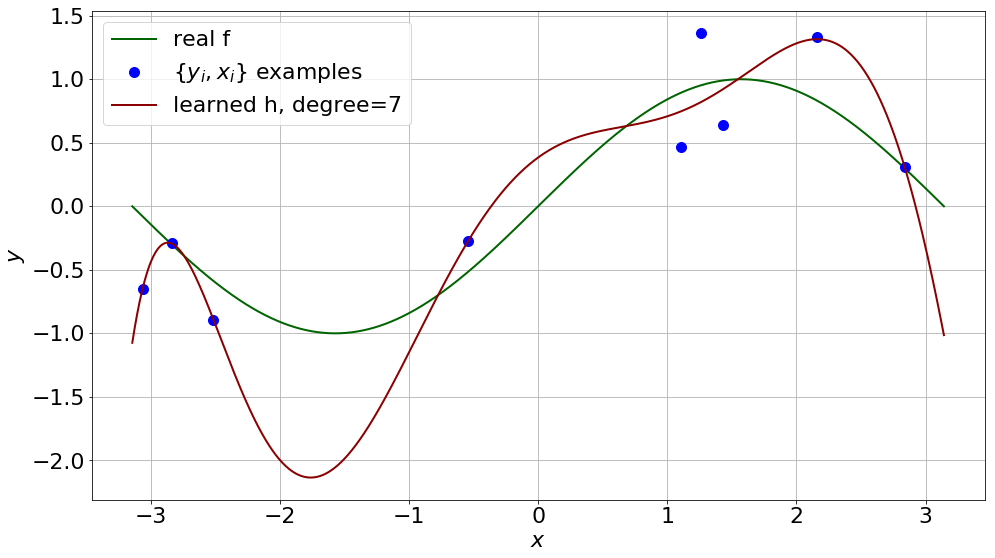

In [16]:
for model in models:
    pl.figure(figsize=FIGSIZE)
    plot_data(*model)
    pl.show()

## Plot the error

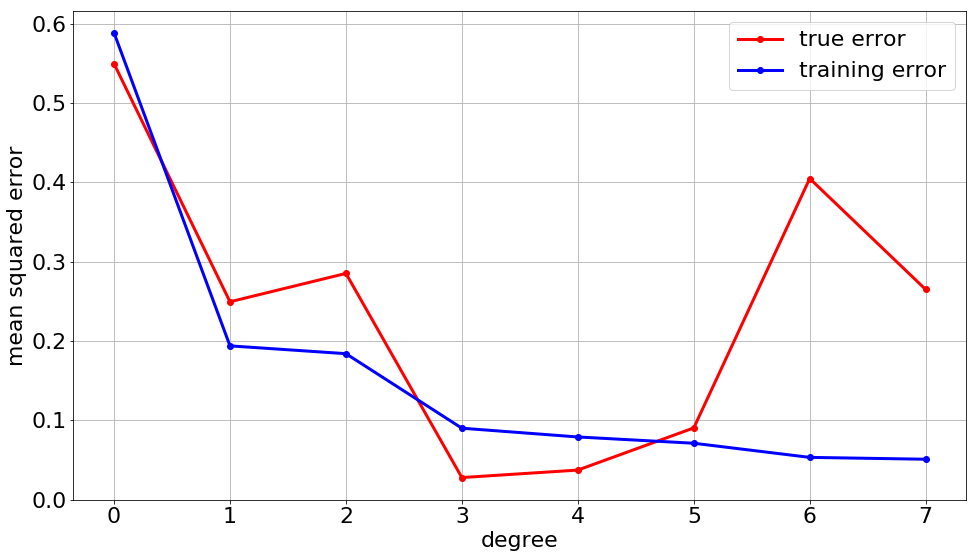

In [17]:
true_error = []
train_error = []

for model, degree in models:
    true_error.append(mean_squared_error(f, model.predict(x_ts[:, np.newaxis])))
    train_error.append(mean_squared_error(y, model.predict(x_tr[:, np.newaxis])))
    
pl.figure(figsize=FIGSIZE)
pl.plot(range(final_degree+1), true_error, 'r-o', linewidth=3, label='true error')
pl.plot(range(final_degree+1), train_error, 'b-o', linewidth=3, label='training error')
pl.xlabel('degree')
pl.ylabel('mean squared error')
pl.legend()
pl.grid()
pl.show()

## Gaussian process regression

Just to demonstrate probabilistic prediction

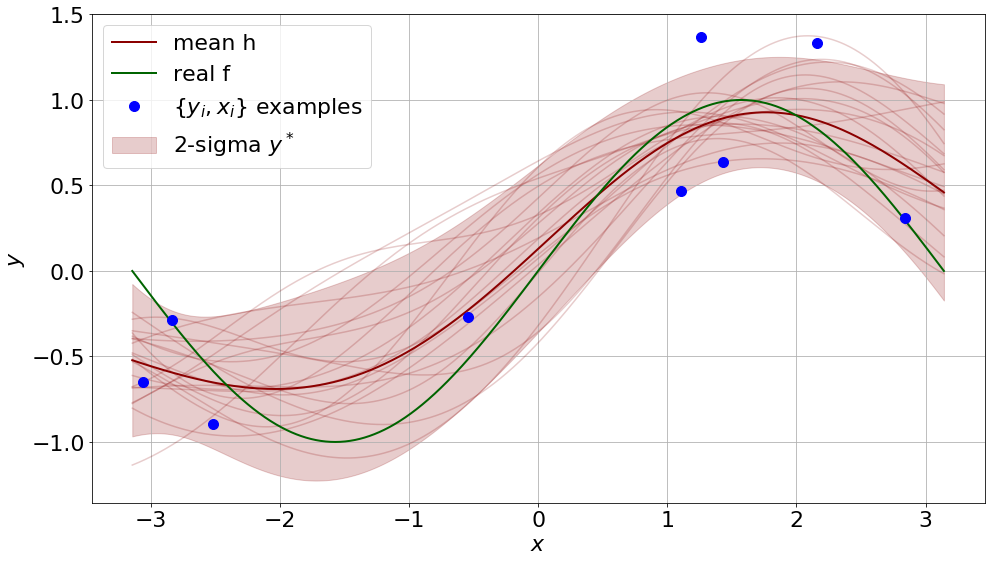

In [18]:
# Radial Basis kernel
kernel = RBF(length_scale=1.)# + WhiteKernel(0.1)

# Fit and predict
gp = GPR(kernel=kernel, alpha=0.1)
gp.fit(x_tr[:, np.newaxis], y)
mean_y, std_y = gp.predict(x_ts[:, np.newaxis], return_std=True)

# Sample the GP
sample_y = gp.sample_y(x_ts[:, np.newaxis], 20)

# Plot the samples
pl.figure(figsize=FIGSIZE)
for ys in sample_y.T:
    pl.plot(x_ts.flatten(), ys, 'darkred', alpha=0.2)

# Plot 2-sigma standard deviation bounds
pl.plot(x_ts.flatten(), mean_y, 'darkred', linewidth=2, label='mean h')
pl.fill_between(x_ts.flatten(), mean_y - std_y * 2, mean_y + std_y * 2, color='darkred', alpha=0.2, label="2-sigma $y^*$")

pl.plot()
plot_data()
pl.show()